In [13]:
import pandas as pd
import numpy as np
import os
import sys
import torch
import yaml
from matplotlib import pyplot as plt

sys.path.append('/home/anna.jungbluth/InstrumentToInstrument/')

from itipy.iti import ITIModule
from itipy.data.geo_datasets import GeoDataset
from itipy.data.geo_editor import BandSelectionEditor, NanMaskEditor, CoordNormEditor, NanDictEditor, RadUnitEditor, ToTensorEditor, StackDictEditor, MeanStdNormEditor, MinMaxNormEditor, Rotate180Editor
from itipy.data.geo_utils import get_split, get_list_filenames, normalize, calculate_norm_from_metrics

In [54]:
msg_path = '/home/data/msg'
goes_path = '/home/data/goes'

config_path = '/home/anna.jungbluth/models/MSG_to_GOES-infrared-1band/config/msg_to_goes.yaml'
config = yaml.safe_load(open(config_path, 'r'))

In [55]:
splits_dict = { 
    "train": {
        "years": [2020], 
        "months": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
        "days": list(range(1, 25))
        },
    "val": {
        "years": [2020],
        "months": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
        "days": list(range(25, 32))
        },
}

fov_radius = config['data']['fov_radius'] if 'fov_radius' in config['data'] else 0.5

norm_config = config['normalization']
msg_norm = calculate_norm_from_metrics(norm_config['A_norm_dir'], split_dict=splits_dict['train'])
goes_norm = calculate_norm_from_metrics(norm_config['B_norm_dir'], split_dict=splits_dict['train'])

In [152]:
msg_bands = config['data']['A_bands']
msg_editors = [
    BandSelectionEditor(target_bands=msg_bands),
    NanDictEditor(key="data", fill_value=0), # Replaces NaNs in data
    Rotate180Editor(key="data"), # Rotate 180 degrees to align north to top of image
    MinMaxNormEditor(norm_dict=msg_norm, key="data"),
    StackDictEditor(allowed_keys = ['data']),
    ToTensorEditor(),
]

goes_bands = config['data']['B_bands']
goes_editors = [
    BandSelectionEditor(target_bands=goes_bands),
    NanDictEditor(key="data", fill_value=0), # Replaces NaNs in data
    MinMaxNormEditor(norm_dict=goes_norm, key="data"),
    StackDictEditor(allowed_keys = ['data']),
    ToTensorEditor(),
]

In [153]:
msg_patch_size = (256, 256)
goes_patch_size = (256, 256)

# msg_patch_size = None
# goes_patch_size = None

In [154]:
msg_dataset = GeoDataset(
    data_dir=msg_path,
    editors=msg_editors,
    splits_dict=splits_dict['train'],
    fov_radius=fov_radius,
    load_coords=False,
    load_cloudmask=False,
    patch_size=msg_patch_size,
)

msg_valid = GeoDataset(
    data_dir=msg_path,
    editors=msg_editors,
    splits_dict=splits_dict['val'],
    fov_radius=fov_radius,
    load_coords=False,
    load_cloudmask=False,
    patch_size=msg_patch_size,
)

goes_dataset = GeoDataset(
    data_dir=goes_path,
    editors=goes_editors,
    splits_dict=splits_dict['train'],
    fov_radius=fov_radius,
    load_coords=False,
    load_cloudmask=False,
    patch_size=goes_patch_size,
)

goes_valid = GeoDataset(
    data_dir=goes_path,
    editors=goes_editors,
    splits_dict=splits_dict['val'],
    fov_radius=fov_radius, 
    load_coords=False,
    load_cloudmask=False,
    patch_size=goes_patch_size,
)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint_path = '/home/anna.jungbluth/models/MSG_to_GOES-infrared-1band/checkpoints/checkpoint_400000.pt'
model = torch.load(checkpoint_path, weights_only=False, map_location=device)

model_ab = model['gen_ab']
model_ab.eval()

model_ba = model['gen_ba']
model_ba.eval()

noise_estimator = model['noise_est'];

# checkpoint_path = '/home/anna.jungbluth/models/MSG_to_GOES-infrared-1band/checkpoints/epoch=199-step=400000.ckpt'

# model = ITIModule(**config['model'])
# checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=device)
# model.load_state_dict(checkpoint['state_dict'])
# model.to(device)
# model.eval();

In [188]:
sample_msg = torch.tensor(msg_valid.sample(4)).to(device)
sample_goes = torch.tensor(goes_valid.sample(4)).to(device)

In [189]:
def unnormalize(norm_dict, bands, data):
    """
    Unnormalize the data using the provided normalization dictionary.
    """
    for i, band in enumerate(bands):
        if len(data.shape) == 3:
            data[i] = (data[i] + 1) * 0.5 * (norm_dict[band]['max'] - norm_dict[band]['min']) + norm_dict[band]['min']
        elif len(data.shape) == 4:
            data[:, i] = (data[:, i] + 1) * 0.5 * (norm_dict[band]['max'] - norm_dict[band]['min']) + norm_dict[band]['min']
    return data

In [190]:
with torch.no_grad():
    output_ab = model_ab((sample_msg))
    # output_ab = model.forwardAB(torch.tensor(sample_msg))

with torch.no_grad():
    noise = noise_estimator((output_ab))
    output_aba = model_ba((output_ab), noise=noise)
    # output_ba = model.forwardBA(torch.tensor(sample_goes))

In [191]:
output_ab_unnorm = unnormalize(msg_norm, msg_bands, output_ab.cpu().detach().numpy())
output_aba_unnorm = unnormalize(goes_norm, goes_bands, output_aba.cpu().detach().numpy())
sample_msg_unnorm = unnormalize(msg_norm, msg_bands, sample_msg.cpu().detach().numpy())
sample_goes_unnorm = unnormalize(goes_norm, goes_bands, sample_goes.cpu().detach().numpy())

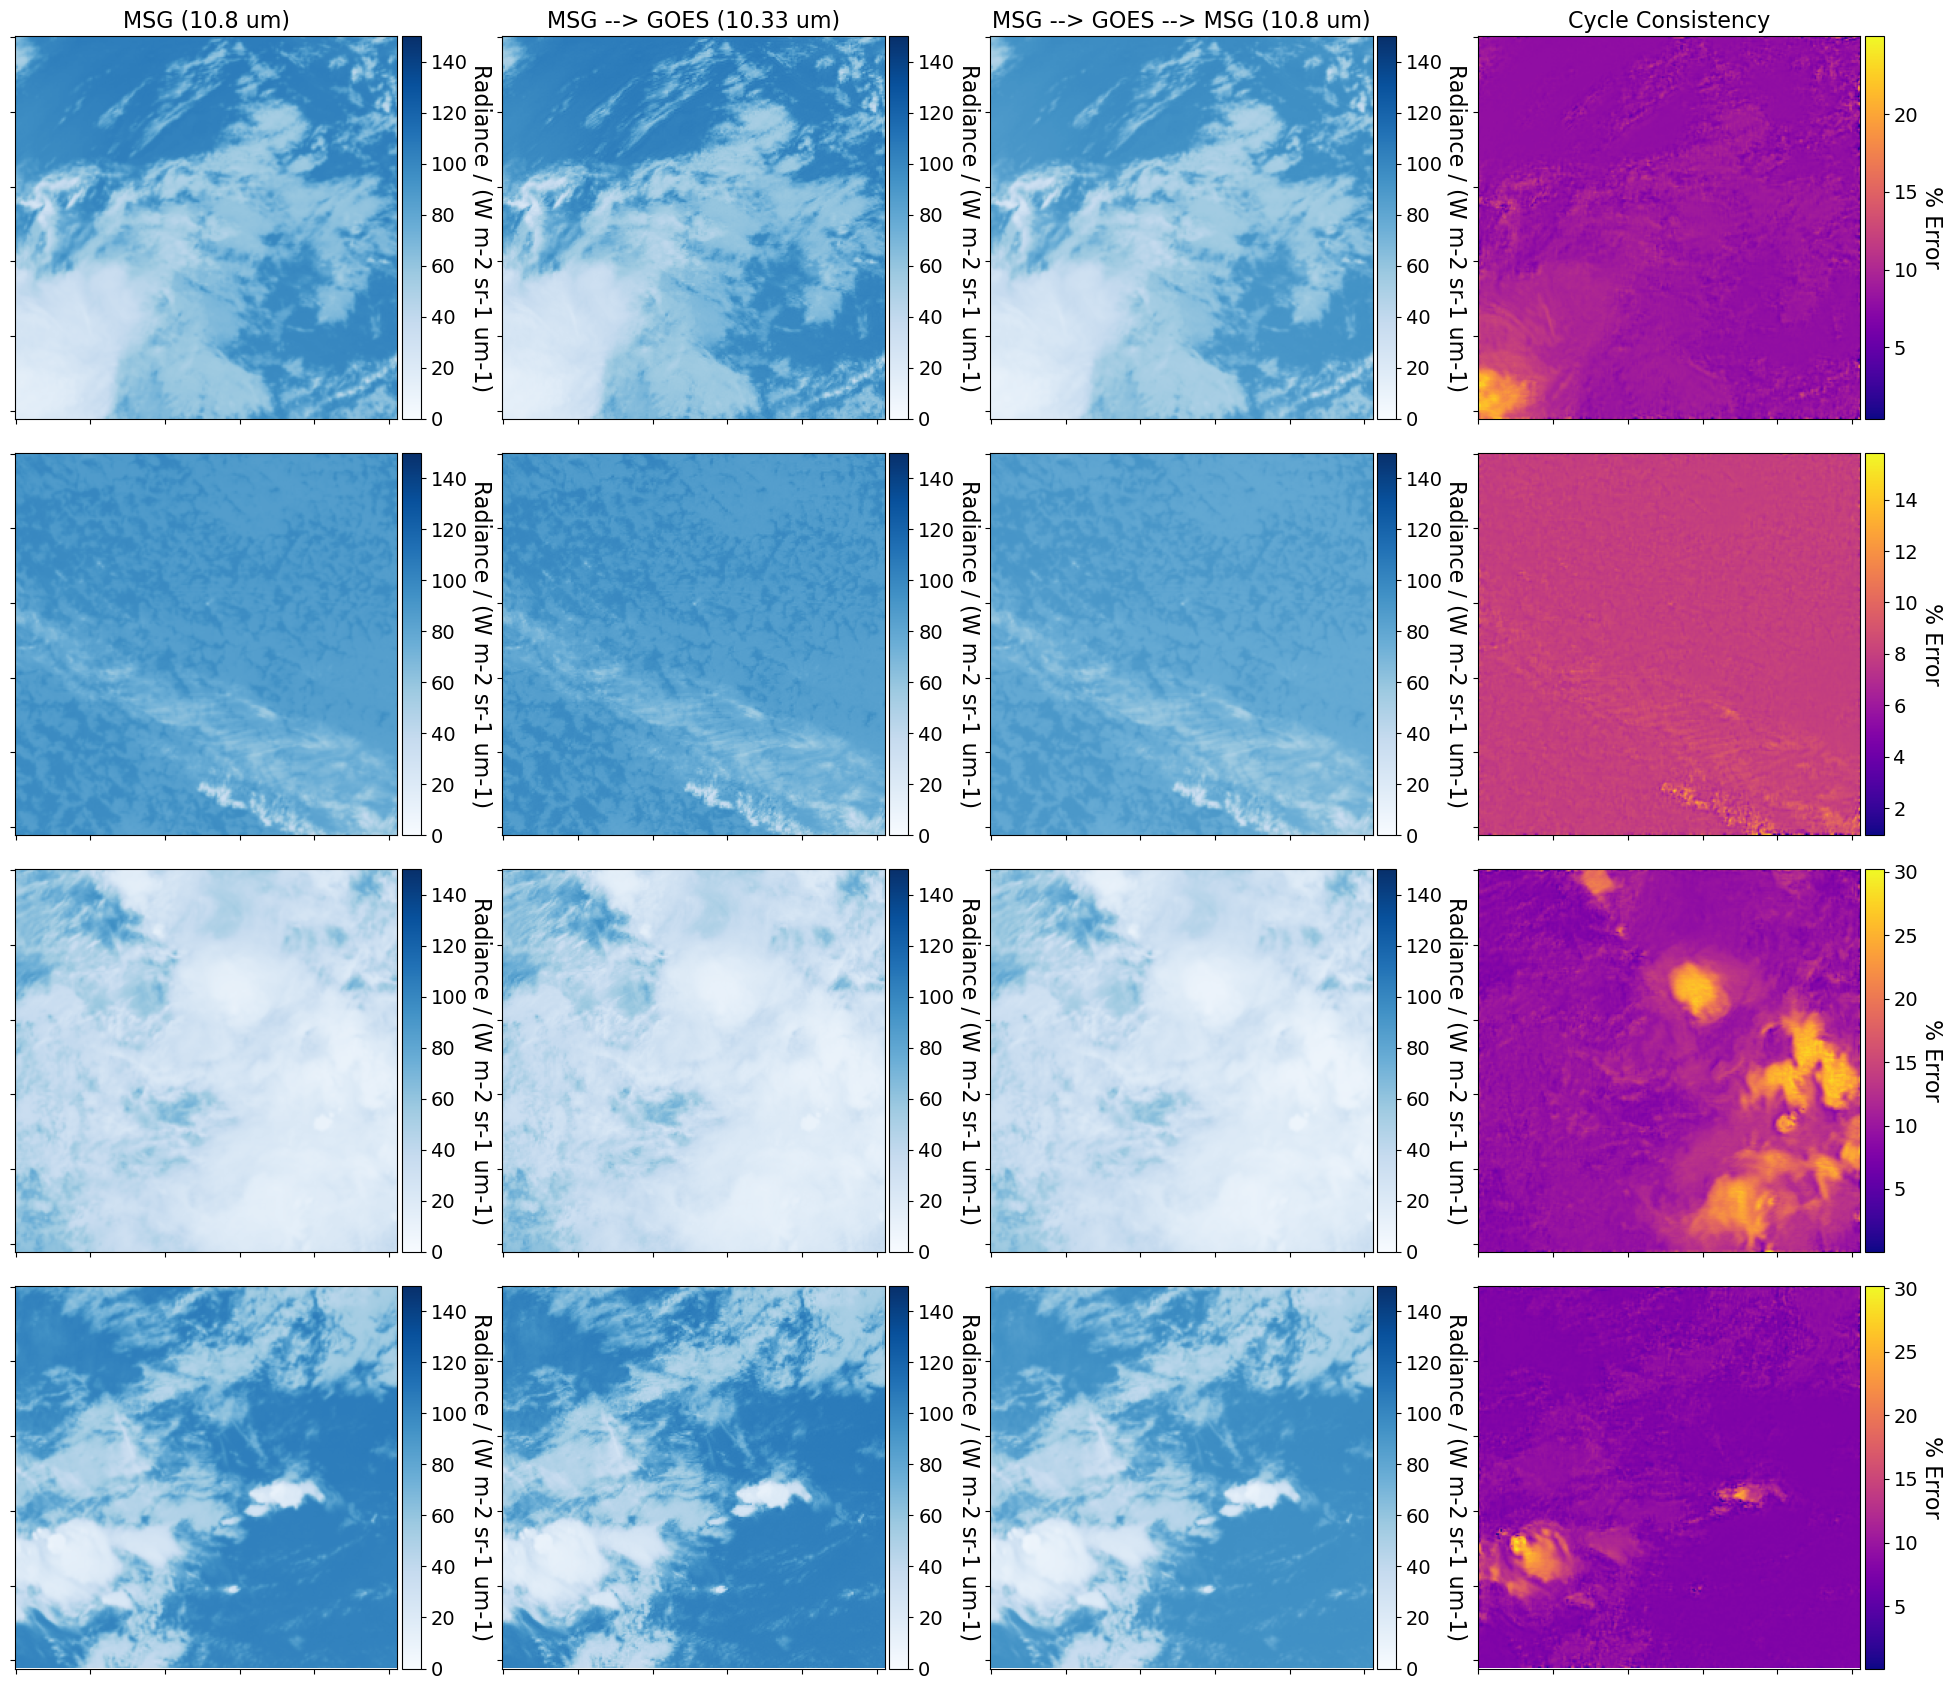

In [ ]:
fontsize = 16
channel = 0

rows = 4
cols = 4
plt.subplots(rows, cols, figsize=(20, 17))

for i in range(rows):
    # MSG
    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(sample_msg_unnorm[i][channel], cmap='Blues', vmin=0, vmax=150)
    # plt.axis("off")
    cbar = plt.colorbar(fraction=0.047, pad=0.01)
    cbar.ax.tick_params(labelsize=fontsize - 2)  # Set the font size for the colorbar
    cbar.set_label("Radiance (W/m²/sr/μm)", fontsize=fontsize, rotation=270, labelpad=18)  # Add a label with the specified font size
    # remove axes numbers
    plt.gca().set_xticklabels([])  # Remove x-axis tick labels
    plt.gca().set_yticklabels([])  # Remove y-axis tick labels
    if i == 0:
        plt.title(f'MSG ({msg_bands[channel]} um)', fontsize=fontsize)

    # GOES (translation)
    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(output_ab_unnorm[i][channel], cmap='Blues', vmin=0, vmax=150)
    # plt.axis("off")
    cbar = plt.colorbar(fraction=0.047, pad=0.01)
    cbar.ax.tick_params(labelsize=fontsize - 2)  # Set the font size for the colorbar
    cbar.set_label("Radiance (W/m²/sr/μm)", fontsize=fontsize, rotation=270, labelpad=18)  # Add a label with the specified font size
    plt.gca().set_xticklabels([])  # Remove x-axis tick labels
    plt.gca().set_yticklabels([])  # Remove y-axis tick labels
    if i == 0:
        plt.title(f'MSG --> GOES ({goes_bands[channel]} um)', fontsize=fontsize)
 
    # MSG (translation)
    plt.subplot(rows, cols, i*cols + 3)
    plt.imshow(output_aba_unnorm[i][channel], cmap='Blues', vmin=0, vmax=150)
    # plt.axis("off")
    cbar = plt.colorbar(fraction=0.047, pad=0.01)
    cbar.ax.tick_params(labelsize=fontsize - 2)  # Set the font size for the colorbar
    cbar.set_label("Radiance (W/m²/sr/μm)", fontsize=fontsize, rotation=270, labelpad=18)  # Add a label with the specified font size
    plt.gca().set_xticklabels([])  # Remove x-axis tick labels
    plt.gca().set_yticklabels([])  # Remove y-axis tick labels
    if i == 0:
        plt.title(f'MSG --> GOES --> MSG ({msg_bands[channel]} um)', fontsize=fontsize)

    # Error
    plt.subplot(rows, cols, i*cols + 4)
    error = np.abs(sample_msg_unnorm[i][channel] - output_aba_unnorm[i][channel])
    percent_error = np.abs((sample_msg_unnorm[i][channel] - output_aba_unnorm[i][channel]) / sample_msg_unnorm[i][channel]) * 100
    # plt.imshow(error, cmap='plasma', vmin=0, vmax=15)
    plt.imshow(percent_error, cmap='plasma')
    # plt.axis("off")
    cbar = plt.colorbar(fraction=0.047, pad=0.01)
    cbar.ax.tick_params(labelsize=fontsize - 2)  # Set the font size for the colorbar
    cbar.set_label("% Error", fontsize=fontsize, rotation=270, labelpad=18)  # Add a label with the specified font size    
    plt.gca().set_xticklabels([])  # Remove x-axis tick labels
    plt.gca().set_yticklabels([])  # Remove y-axis tick labels
    if i == 0:
        plt.title(f'Cycle Consistency', fontsize=fontsize)

plt.tight_layout()

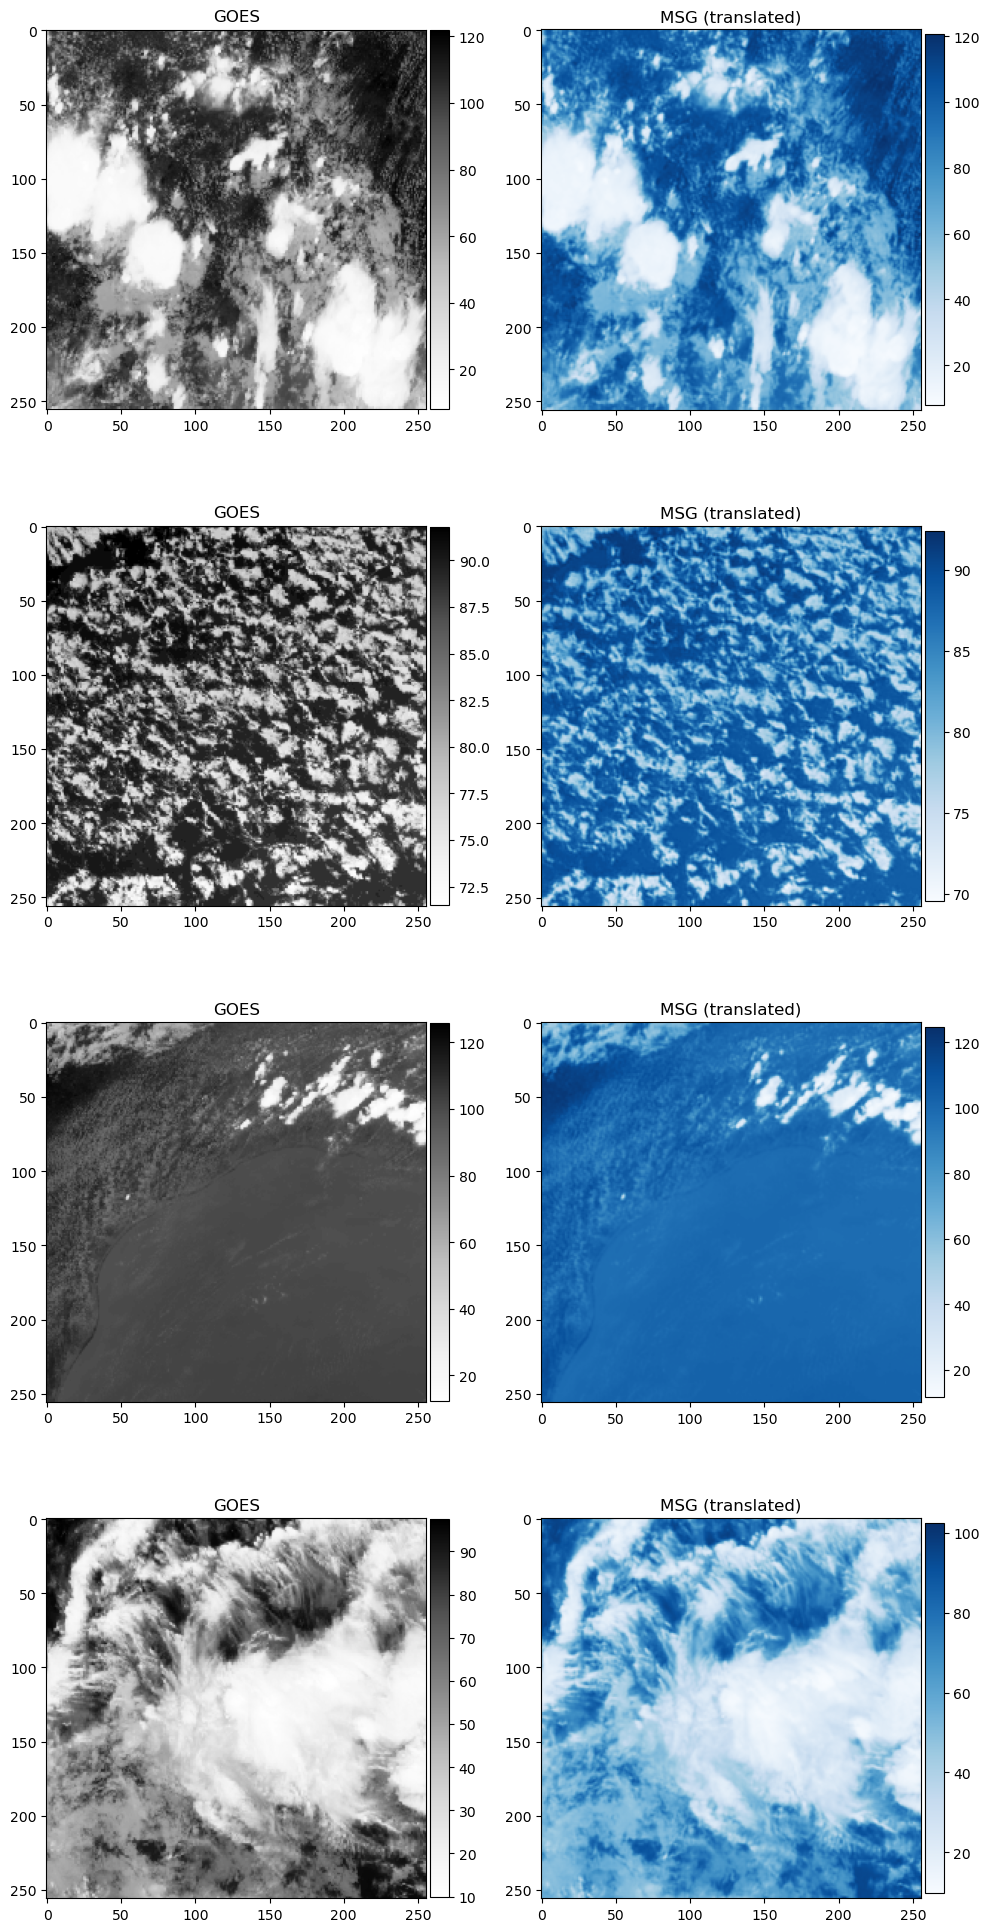

In [44]:
rows = 4
cols = 2
plt.subplots(rows, cols, figsize=(10, 20))

for i in range(rows):
    # MSG
    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(sample_goes_unnorm[i][0], cmap='Greys')
    plt.colorbar(fraction=0.047, pad=0.01)
    plt.title('GOES')

    # GOES
    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(output_ba_unnorm[i][0], cmap='Blues')
    plt.colorbar(fraction=0.046, pad=0.01)
    plt.title('MSG (translated)')
plt.tight_layout()

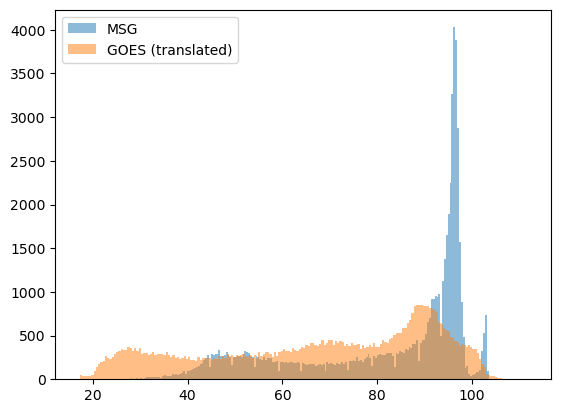

In [ ]:
plt.hist(sample_msg_unnorm[0][0].flatten(), bins=200, alpha=0.5, label='MSG')
plt.hist(output_ab_unnorm[0][0].flatten(), bins=200, alpha=0.5, label='GOES (translated)')
plt.legend()

In [85]:
# loop through validation set

for i in range(5):
    sample_msg = msg_valid[i].to(device).unsqueeze(0)

    with torch.no_grad():
        output_ab = model_ab(sample_msg)

    output_ba_unnorm = unnormalize(goes_norm, goes_bands, output_ba.cpu().detach().numpy())

    print("max: ", np.max(sample_msg.cpu().detach().numpy()), "min: ", np.min(sample_msg.cpu().detach().numpy()))
    print("max: ", np.max(output_ab.cpu().detach().numpy()), "min: ", np.min(output_ab.cpu().detach().numpy()))



max:  0.030864144 min:  -0.93827164
max:  0.044127464 min:  -0.9217802
max:  0.098765425 min:  -0.5823046
max:  0.10101433 min:  -0.60398436
max:  0.01028804 min:  -0.81893003
max:  0.028636243 min:  -0.82936347
max:  0.13580248 min:  -0.16872431
max:  0.1334974 min:  -0.18181667
max:  0.10905348 min:  -0.78600824
max:  0.114389725 min:  -0.8015482
